In [15]:
"""This is the data cleaning project"""

'This is the data cleaning project'

In [3]:
import csv
import collections
import re
import pandas_datareader as pdr
from datetime import datetime 

def main():
    Data = readdata()
    Formated_Data = [Data[0]] + cleandata()
    Complete_Data = missing(Formated_Data) #Find and deal with missing data
    Clean_Data = wrong(Complete_Data)
    with open('Clean_Data_Out.csv', 'w') as fp:
        writer = csv.writer(fp)
        writer.writerows(Clean_Data)  # write data
    print("Output Data Complete!")
    return Clean_Data
        
    

ModuleNotFoundError: No module named 'pandas_datareader'

In [4]:
#Read Data
def readdata():
    # This function reads data from the original dataset
    with open('all_stocks_5yr.csv') as fp:
        reader = csv.reader(fp)
        data = list(reader)
        findata = [i for i in data if i[6] != 'XL']
    return findata

def assetlist():
    # This function returns a set of tickers of S&P500 stocks
    n = readdata()
    k = [ i[6] for i in n]
    return set(k)


In [4]:
# Format Data
def cleanrow(row):
    namepattern = r'[A-Z]*' # To check that all tickers contains only capital letters
    datepattern = r'(\d{4})-(\d{2})-(\d{2})*' # To check that the dates are in the YYYY-MM-DD format
    matchname = re.search(namepattern, row[6])
    matchdate = re.search(datepattern, row[0])
    
    new_row = [0, 0, 0, 0, 0, 0, 0]
    new_row[0] = row[0] if bool(matchdate) == True else None 
    new_row[1] = round(float(row[1]),2) if row[1] else None
    new_row[2] = round(float(row[2]),2) if row[2] else None
    new_row[3] = round(float(row[3]),2) if row[3] else None
    new_row[4] = round(float(row[4]),2) if row[4] else None
    new_row[5] = int(row[5]) if row[5].isdigit() else None
    new_row[6] = row[6] if bool(matchname) == True else None
    # format the original data, also check for missing data and some cases of wrong data
    # missing and wrong data are replaced by None so we could deal with them more efficiently
    # in the future 
    return new_row

def cleandata():
    dataset = readdata()
    data = dataset[1:]
    for i in range(len(data)):
        data[i] = cleanrow(data[i])
    return data


In [5]:
# Find possible wrong value
# Find missing value

def missing_value(data):
    missing_value = []
    
    for i in range(1, len(data)):
        if None in data[i]:
            missing_value.append(i)
            # find the index of rows with missing value  
        else:
            pass
    return missing_value


In [17]:
# Using webcrawler to fill in the missing data
# and check for the wrong data
import pandas_datareader as pdr
from datetime import datetime

# Deprecated webcrawler function (Not complete)
#def dateconvert(date):
#    daysplit = date.split('-')
#    year = int(daysplit[0])
#    month = int(daysplit[1])
#    day = int(daysplit[2])
#    day2 = datetime(year, month, day)
#    day1 = datetime(2013, 1, 1)
#    delta = day2-day1
#   # -- 2013-01-01 = 1357016400
#    sfbd = (delta.days)*86400+1357016400
#    return sfbd
#    # This function converts the string date in the dataset into 64-bit date used by Yahoo Finance.
#
#
#def YHFinance(ticker, day, category):
#    url = f'https://finance.yahoo.com/quote/{ticker}/history?period1={day}&period2={day}&interval=1d&filter=history&frequency=1d'
#    print(url)
#    code = requests.get(url)
#    plain = code.text
#    s = BeautifulSoup(plain, "html.parser")
#    return s

def get_data(ticker, date1, date2, category):
    year1, month1, day1 = int(date1.split('-')[0]), int(date1.split('-')[1]), int(date1.split('-')[2])
    year2, month2, day2 = int(date2.split('-')[0]), int(date2.split('-')[1]), int(date2.split('-')[2])
    data = pdr.get_data_yahoo(symbols = ticker, start = datetime(year1,month1,day1), end = datetime(year2, month2, day2))
    n = data[category]
    return round(float(n[0]),2)

def get_missing(row1, row2, data):
    for i in range(len(row1)):
        if row1[i] == None:
            category = data[0][i].capitalize()
            datapoint = get_data(row1[6], row1[0], row2[0], category)
            row1[i] = datapoint
        else:
            pass
    return row1

def missing(data):
    print("Finding Missing Values...")
    missing_rows = missing_value(data)
    print("Fill in Missing Values...")
    for i in missing_rows:
        print(data[i])
        get_missing(data[i], data[i+1], data)
        print(data[i])
    print("Missing Data Resolution Complete!")
    return data


ModuleNotFoundError: No module named 'pandas_datareader'

In [18]:
def wrong_value(data):    
    suspicious_high = []
    suspicious_low = []
    suspicious_openclose = []
    
    for i in range(1, len(data)):
        if ((data[i][2] - data[i][3])/data[i][3]) >= 0.4:
            suspicious_high.append(i)
            suspicious_low.append(i)
            # find suspicious high-low gap
        elif abs((data[i][1] - data[i][4])/data[i][4]) >= 0.4:
            suspicious_openclose.append(i)
            # find suspicious open-close gap
        elif data[i][2] < data[i][1] or data[i][2] < data[i][3] or data[i][2] < data[i][4]:
            suspicious_high.append(i)
            # find low, open, close value greater than the high value
        elif data[i][3] > data[i][1] or data[i][3] > data[i][2] or data[i][3] > data[i][4]:
            suspicious_low.append(i)
            # find high, open, close value less than low value
    return suspicious_high, suspicious_low, suspicious_openclose
    
def get_high(data, row1, row2, cat_num = 2):
    datapoint = get_data(row1[6], row1[0], row2[0], data[0][cat_num].capitalize())
    row1[cat_num] = datapoint
    return row1

def get_low(data, row1, row2, cat_num = 3):
    datapoint = get_data(row1[6], row1[0], row2[0], data[0][cat_num].capitalize())
    row1[cat_num] = datapoint
    return row1

def get_open(data, row1, row2, cat_num = 1):
    datapoint = get_data(row1[6], row1[0], row2[0], data[0][cat_num].capitalize())
    row1[cat_num] = datapoint
    return row1

def get_close(data, row1, row2, cat_num = 4):
    datapoint = get_data(row1[6], row1[0], row2[0], data[0][cat_num].capitalize())
    row1[cat_num] = datapoint
    return row1

def wrong(data):
    print("Finding Potential Wrong Values")
    wrong_high_rows, wrong_low_rows, wrong_openclose_rows = wrong_value(data)
    print("Correcting Suspicious 'High' Values")
    for i in wrong_high_rows:
        print(i)
        get_high(data, data[i], data[i+1])
        print(data[i])
    print("Suspicious 'High' Values Resolution Complete")
    print("Correcting Suspicious 'Low' Values")
    for i in wrong_low_rows:
        print(i)
        get_low(data, data[i], data[i+1])
        print(data[i])
    print("Suspicious 'Low' Values Resolution Complete")
    print("Correcting Suspicious 'Open' and 'Close' Values")
    for i in wrong_openclose_rows:
        print(i)
        get_open(data, data[i], data[i+1])
        get_close(data, data[i], data[i+1])
        print(data[i])
    print("Suspicious 'Open' and 'Close' Values Resolution Complete")
    print("Wrong Values Resolution Complete")
    return data

In [8]:
main()

Finding Missing Values...
Fill in Missing Values...
['2017-07-26', None, None, None, 69.08, 3, 'BHF']
['2017-07-26', 69.08, 69.08, 69.08, 69.08, 3, 'BHF']
['2015-07-17', None, 88.76, 88.24, 88.72, 2056819, 'DHR']
['2015-07-17', 67.08, 88.76, 88.24, 88.72, 2056819, 'DHR']
['2016-01-12', None, None, None, 88.55, 0, 'DHR']
['2016-01-12', 67.95, 67.95, 66.26, 88.55, 0, 'DHR']
['2015-07-17', None, 48.49, 47.85, 47.92, 1246786, 'ES']
['2015-07-17', 48.3, 48.49, 47.85, 47.92, 1246786, 'ES']
['2016-07-01', None, None, None, 49.54, 0, 'FTV']
['2016-07-01', 49.4, 54.34, 48.4, 49.54, 0, 'FTV']
['2015-07-17', None, 47.31, 46.83, 46.99, 1229513, 'O']
['2015-07-17', 47.2, 47.31, 46.83, 46.99, 1229513, 'O']
['2016-01-12', None, None, None, 52.43, 0, 'O']
['2016-01-12', 52.52, 52.59, 51.76, 52.43, 0, 'O']
['2015-06-09', None, None, None, 526.09, 12135, 'REGN']
['2015-06-09', 526.09, 526.09, 526.09, 526.09, 12135, 'REGN']
['2016-04-07', None, None, None, 41.56, 0, 'UA']
['2016-04-07', 41.79, 41.83, 41.

[['date', 'open', 'high', 'low', 'close', 'volume', 'Name'],
 ['2013-02-08', 15.07, 15.12, 14.63, 14.75, 8407500, 'AAL'],
 ['2013-02-11', 14.89, 15.01, 14.26, 14.46, 8882000, 'AAL'],
 ['2013-02-12', 14.45, 14.51, 14.1, 14.27, 8126000, 'AAL'],
 ['2013-02-13', 14.3, 14.94, 14.25, 14.66, 10259500, 'AAL'],
 ['2013-02-14', 14.94, 14.96, 13.16, 13.99, 31879900, 'AAL'],
 ['2013-02-15', 13.93, 14.61, 13.93, 14.5, 15628000, 'AAL'],
 ['2013-02-19', 14.33, 14.56, 14.08, 14.26, 11354400, 'AAL'],
 ['2013-02-20', 14.17, 14.26, 13.15, 13.33, 14725200, 'AAL'],
 ['2013-02-21', 13.62, 13.95, 12.9, 13.37, 11922100, 'AAL'],
 ['2013-02-22', 13.57, 13.6, 13.21, 13.57, 6071400, 'AAL'],
 ['2013-02-25', 13.6, 13.76, 13.0, 13.02, 7186400, 'AAL'],
 ['2013-02-26', 13.14, 13.42, 12.7, 13.26, 9419000, 'AAL'],
 ['2013-02-27', 13.28, 13.62, 13.18, 13.41, 7390500, 'AAL'],
 ['2013-02-28', 13.49, 13.63, 13.39, 13.43, 6143600, 'AAL'],
 ['2013-03-01', 13.37, 13.95, 13.32, 13.61, 7376800, 'AAL'],
 ['2013-03-04', 13.5, 14.0

In [9]:
#The other part of data cleaning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [11]:
df = pd.read_csv(
    '/Users/niweichong/Desktop/Git/Tools-Project-Data-Cleaning-master/Tools-Project-Data-Cleaning/Clean_Data_Out.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [12]:
df.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64

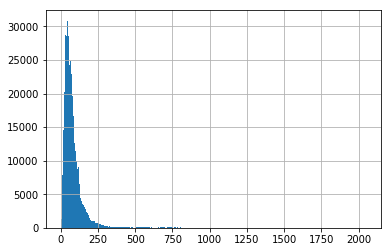

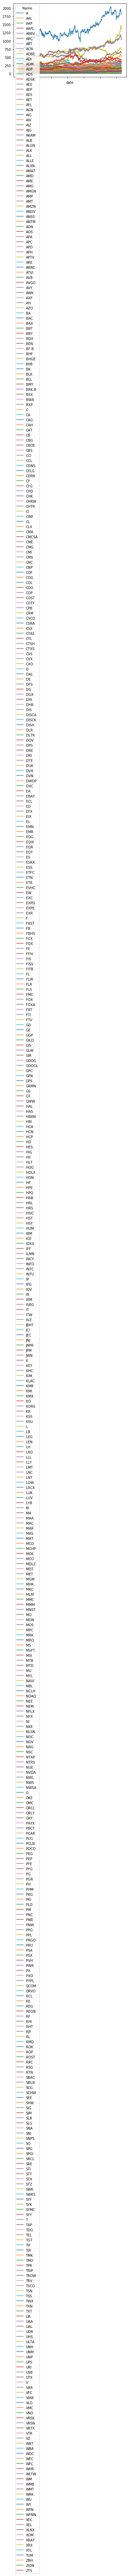

In [14]:
#plot histogram of ? and all the stock data
df.open.hist(bins=500)
df.set_index(['date','Name']).unstack().open.plot()

AxesSubplot(0.125,0.125;0.775x0.755)


date        Name 
2015-07-02  NI      -0.951660
2015-07-20  EBAY    -0.898506
2014-08-07  DISCK   -0.693511
            DISCA   -0.661197
2015-07-01  BAX     -0.638836
2014-01-16  BBY     -0.364364
2017-09-14  NWL     -0.354583
2017-11-01  EVHC    -0.332712
2016-11-01  YUM     -0.327661
2017-01-31  UAA     -0.324840
2014-11-03  A       -0.324768
2016-10-11  ILMN    -0.316069
2017-01-31  UA      -0.308236
2013-12-06  ULTA    -0.302394
2017-07-05  BHGE    -0.298651
2014-10-16  NFLX    -0.289679
2017-01-03  XRX     -0.289212
2016-02-09  WMB     -0.282116
2017-08-18  FL      -0.279578
2015-07-17  DHR     -0.279148
2016-07-05  DHR     -0.269236
2016-01-12  DHR     -0.268177
2017-04-03  HPE     -0.263645
2017-11-21  SIG     -0.261582
2017-09-15  MRO     -0.258627
2013-07-30  MOS     -0.256427
2013-07-26  EXPE    -0.254177
2016-11-10  CAG     -0.248120
2016-11-01  ARNC    -0.245904
2017-09-01  HPE     -0.240960
                       ...   
2015-10-21  KLAC     0.195610
2015-01-21  NFLX     0

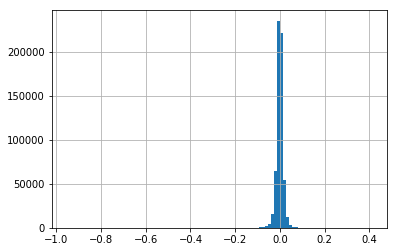

In [22]:
#Rank, plot and find unusual returns
def rank_returns():
    df_open = df.set_index(['date','Name']).unstack().open
    df_return = np.log(df_open).diff().stack()
    print(df_return.hist(bins=100))
    return df_return.sort_values()

rank_returns()

In [26]:
def castDate(date):
    try:
        date = pd.Timestamp(date)
    except:
        date = np.datetime64('NaT')
    return date
df.date = list(map(castDate,df.date))


,date,open,high,low,close,volume,Name
410642,2015-06-26,46.53,46.53,46.10,46.25,2947353,NI
410643,2015-06-29,46.30,46.81,45.92,45.95,2179037,NI
410644,2015-06-30,45.61,46.02,45.44,45.59,2910080,NI
410645,2015-07-01,45.61,45.71,45.01,45.45,3740554,NI
410646,2015-07-02,17.61,17.94,16.91,16.99,16010299,NI
410647,2015-07-06,16.95,17.09,16.65,16.84,11162984,NI
410648,2015-07-07,16.96,17.14,16.70,17.12,10865443,NI
410649,2015-07-08,17.09,17.32,16.95,17.14,7037833,NI
410650,2015-07-09,17.47,17.47,16.75,16.75,6645525,NI


In [ ]:
#Find wrong data of "NI"
df[(df.Name=='NI')&(df.date>pd.Timestamp('2015-06-25'))&(df.date<pd.Timestamp('2015-07-10'))]

#Find Ebay sharesplit 
Ebay = df[df['Name'] == 'EBAY']
Ebay.plot(kind='line',x='date',y='open')

#No stock splits history 
#https://finance.yahoo.com/calendar/splits?from=2015-07-19&to=2015-07-25&day=2015-07-20

In [46]:
class Equity:
    def __init__(self, name):
        self.name = name
        self.history = [dataset[0]]+[i for i in cleandata if i[6] == name]
    
    def RoR(self, day1, day2):
        s = [i[4] for i in self.history if i[0] == day1][0]
        St = [i[4] for i in self.history if i[0] == day2][0]
        return (St/s)-1

In [137]:
import pandas as pd
import numpy as np

def data_analysis():
    stock_symbols = {'NOV', 'PDCO'}  # <- can input as many stock stickers as needed 
    data = pd.read_csv('Clean_Data_Out.csv')
    
    # Filter to select only 5 stocks
    data = data.loc[data['Name'].isin(stock_symbols)]
    
    # Convert Date column from string to datetime
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
    
    # Add column for daily returns
    data['daily_return'] = np.log(data['close'] / data['open'])
    
    
    treasury_data = pd.read_csv('Treasury Bill Yield Curve.csv')
    
    # T-bill not available for certain dates (dates are not consecutive). 
    # Use linear interpolation to proxy for the t-bill rate for that date.
    for i, row in treasury_data.iterrows():
        if row['10 Yr T bill'] == 'NA':
            # Assuming that isnull does not occur when i == 0 and when i == len(treasury_data) - 1
            treasury_data['10 Yr T bill'][i] = 0.5 * (
                treasury_data['10 Yr T bill'][i - 1] +
                treasury_data['10 Yr T bill'][i + 1]
            )
    
    # Convert Date column from string to datetime
    treasury_data['Date'] = pd.to_datetime(treasury_data['Date'], format='%m/%d/%Y')
    
    # Reformat 10 Yr T bill return into decimals (original data was in %)
    treasury_data['10 Yr T bill returns'] = treasury_data['10 Yr T bill'] / 100
    
    
    # Calculate SP 500 returns
    treasury_data['SP 500 Returns'] = treasury_data['SP 500 '] / treasury_data['SP 500 '].shift() - 1
    
    # Perform a left join
    data = pd.merge(data, treasury_data, left_on='date', right_on='Date', how='left')
    
        
    # Calculate Beta for individual stock. 
    
    data['CAPM return'] = 0
    for stock_symbol in stock_symbols:
        stock_data = data.loc[data['Name'] == stock_symbol]
        
        # Covariance between individual stock vs. market (SP 500):
        cov = np.mean(
            stock_data['daily_return'] - np.mean(stock_data['daily_return']) *
            stock_data['SP 500 Returns'] - np.mean(stock_data['SP 500 Returns'])
        )
        
        # Variance of market
        var = np.var(stock_data['SP 500 Returns'])
        
        # Beta = Covariance [Return of Asset & Return of Market] / Variance [Return of Market]
        beta = cov / var
        
        
        # CAPM Return = Rf + Beta * (Mkt Return - Rf)
        # Rf = T bill rate
        # Mkt Return = SP 500
        data.loc[data['Name'] == stock_symbol, 'CAPM return'] = stock_data['10 Yr T bill returns'] + beta * (stock_data['SP 500 Returns'] - stock_data['10 Yr T bill returns'])
    
    # Finally, calculate the difference between actual daily return vs. CAPM predicted return
    data['residuals'] = data['CAPM return'] - data['daily_return']
    return data

data = data_analysis()
data.to_csv('Cleaned_Data_Analyzed.csv')
